# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

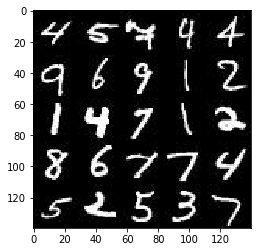

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

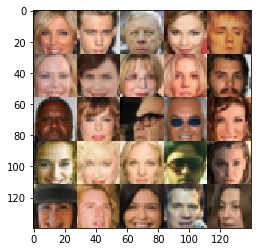

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input');
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, z_input, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    # for leaky relu
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28x28xchannel
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)

        # input 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*x2, x2)

        # input 7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(x3*alpha, x3)

        # input 4x4x256 - flatten it
        x4 = tf.reshape(relu3, [-1, 4*4*256])
        logits = tf.layers.dense(x4, 1)
        output = tf.sigmoid(logits)

    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # for leaky relu
    alpha = 0.2

    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # input 4x4x256, reshape to conv net
        x1 = tf.layers.dense(z, 4*4*256)
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.maximum(alpha * x1, x1)

        # input 4x4x256
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        # input 7x7x128
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
       
        # input 14x14x64
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # generator loss
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # discriminator loss
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_train, g_train = model_opt(d_loss, g_loss, learning_rate, beta1)    

    batch = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch += 1                
                batch_images = batch_images*2 
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train, feed_dict={real_input:batch_images, z_input: batch_z, lr: learning_rate})
                sess.run(g_train, feed_dict={real_input:batch_images, z_input: batch_z, lr: learning_rate})
                
                # show loss every so often to determine how network is doing
                if batch % 20 == 0:
                    loss_d = d_loss.eval({real_input: batch_images, z_input: batch_z})
                    loss_g = g_loss.eval({z_input:batch_z})
                    
                    print("Training step: {}, Discriminator loss: {:.3f}, Generator loss: {:.3f}\n".format(batch, loss_d, loss_g))
                
                if batch % 100 == 0:
                    show_generator_output(sess, 10, z_input, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Training step: 20, Discriminator loss: 1.410, Generator loss: 0.442

Training step: 40, Discriminator loss: 1.222, Generator loss: 0.577

Training step: 60, Discriminator loss: 1.063, Generator loss: 0.680

Training step: 80, Discriminator loss: 1.207, Generator loss: 0.612

Training step: 100, Discriminator loss: 1.014, Generator loss: 0.800



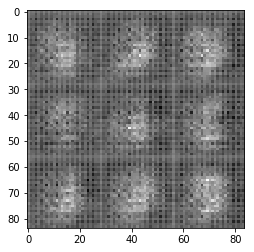

Training step: 120, Discriminator loss: 1.206, Generator loss: 0.645

Training step: 140, Discriminator loss: 1.208, Generator loss: 0.679

Training step: 160, Discriminator loss: 1.145, Generator loss: 0.751

Training step: 180, Discriminator loss: 1.156, Generator loss: 0.666

Training step: 200, Discriminator loss: 0.976, Generator loss: 0.902



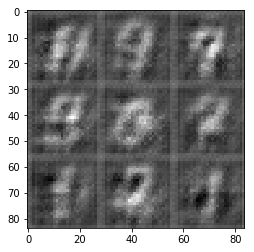

Training step: 220, Discriminator loss: 1.022, Generator loss: 0.847

Training step: 240, Discriminator loss: 1.082, Generator loss: 0.751

Training step: 260, Discriminator loss: 0.932, Generator loss: 0.845

Training step: 280, Discriminator loss: 0.935, Generator loss: 0.891

Training step: 300, Discriminator loss: 0.918, Generator loss: 0.889



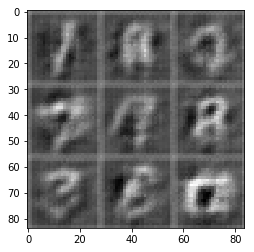

Training step: 320, Discriminator loss: 0.944, Generator loss: 0.815

Training step: 340, Discriminator loss: 0.959, Generator loss: 0.840

Training step: 360, Discriminator loss: 1.067, Generator loss: 0.720

Training step: 380, Discriminator loss: 0.946, Generator loss: 0.798

Training step: 400, Discriminator loss: 1.014, Generator loss: 0.845



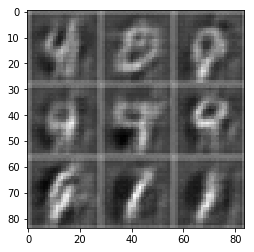

Training step: 420, Discriminator loss: 0.989, Generator loss: 0.802

Training step: 440, Discriminator loss: 1.055, Generator loss: 0.878

Training step: 460, Discriminator loss: 0.964, Generator loss: 0.853

Training step: 480, Discriminator loss: 1.018, Generator loss: 0.904

Training step: 500, Discriminator loss: 0.978, Generator loss: 0.918



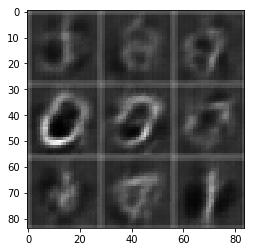

Training step: 520, Discriminator loss: 1.038, Generator loss: 0.821

Training step: 540, Discriminator loss: 0.960, Generator loss: 0.966

Training step: 560, Discriminator loss: 1.001, Generator loss: 0.786

Training step: 580, Discriminator loss: 1.012, Generator loss: 0.717

Training step: 600, Discriminator loss: 0.877, Generator loss: 1.086



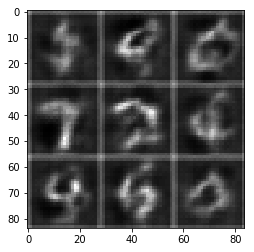

Training step: 620, Discriminator loss: 1.005, Generator loss: 0.803

Training step: 640, Discriminator loss: 0.990, Generator loss: 0.771

Training step: 660, Discriminator loss: 1.122, Generator loss: 1.128

Training step: 680, Discriminator loss: 1.025, Generator loss: 0.737

Training step: 700, Discriminator loss: 0.810, Generator loss: 1.041



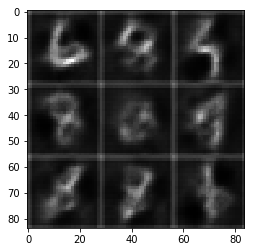

Training step: 720, Discriminator loss: 0.874, Generator loss: 1.059

Training step: 740, Discriminator loss: 0.874, Generator loss: 0.949

Training step: 760, Discriminator loss: 0.883, Generator loss: 1.010

Training step: 780, Discriminator loss: 0.966, Generator loss: 0.923

Training step: 800, Discriminator loss: 0.982, Generator loss: 0.812



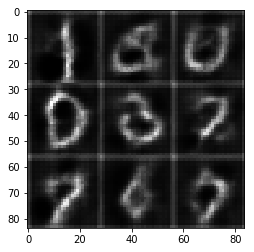

Training step: 820, Discriminator loss: 0.983, Generator loss: 0.780

Training step: 840, Discriminator loss: 0.886, Generator loss: 0.770

Training step: 860, Discriminator loss: 0.949, Generator loss: 0.812

Training step: 880, Discriminator loss: 0.876, Generator loss: 0.877

Training step: 900, Discriminator loss: 0.839, Generator loss: 0.936



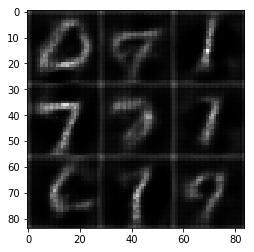

Training step: 920, Discriminator loss: 0.751, Generator loss: 0.965

Training step: 940, Discriminator loss: 0.863, Generator loss: 0.930

Training step: 960, Discriminator loss: 0.948, Generator loss: 0.894

Training step: 980, Discriminator loss: 0.763, Generator loss: 1.030

Training step: 1000, Discriminator loss: 0.821, Generator loss: 0.979



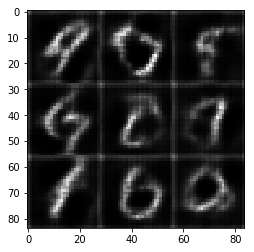

Training step: 1020, Discriminator loss: 0.750, Generator loss: 1.064

Training step: 1040, Discriminator loss: 0.916, Generator loss: 1.243

Training step: 1060, Discriminator loss: 0.834, Generator loss: 1.018

Training step: 1080, Discriminator loss: 1.010, Generator loss: 1.431

Training step: 1100, Discriminator loss: 1.104, Generator loss: 0.969



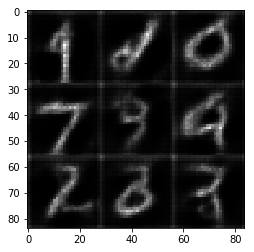

Training step: 1120, Discriminator loss: 0.790, Generator loss: 0.826

Training step: 1140, Discriminator loss: 0.715, Generator loss: 0.946

Training step: 1160, Discriminator loss: 0.790, Generator loss: 1.137

Training step: 1180, Discriminator loss: 0.721, Generator loss: 1.170

Training step: 1200, Discriminator loss: 0.739, Generator loss: 1.133



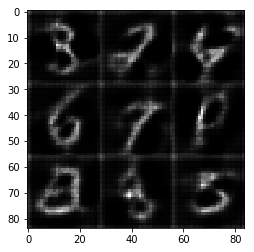

Training step: 1220, Discriminator loss: 0.817, Generator loss: 0.811

Training step: 1240, Discriminator loss: 0.645, Generator loss: 1.427

Training step: 1260, Discriminator loss: 0.800, Generator loss: 1.291

Training step: 1280, Discriminator loss: 0.640, Generator loss: 1.134

Training step: 1300, Discriminator loss: 0.823, Generator loss: 0.827



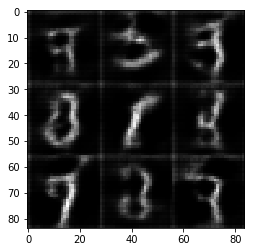

Training step: 1320, Discriminator loss: 0.799, Generator loss: 0.873

Training step: 1340, Discriminator loss: 0.850, Generator loss: 1.027

Training step: 1360, Discriminator loss: 0.640, Generator loss: 1.053

Training step: 1380, Discriminator loss: 0.811, Generator loss: 0.909

Training step: 1400, Discriminator loss: 1.241, Generator loss: 0.452



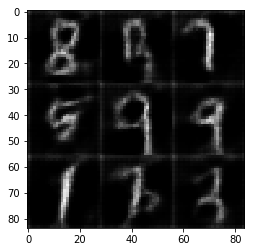

Training step: 1420, Discriminator loss: 0.842, Generator loss: 0.984

Training step: 1440, Discriminator loss: 0.640, Generator loss: 0.996

Training step: 1460, Discriminator loss: 0.907, Generator loss: 1.471

Training step: 1480, Discriminator loss: 0.670, Generator loss: 1.320

Training step: 1500, Discriminator loss: 1.009, Generator loss: 0.655



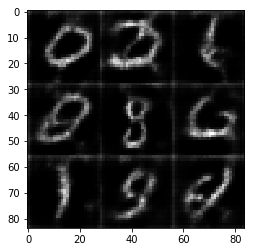

Training step: 1520, Discriminator loss: 0.694, Generator loss: 1.102

Training step: 1540, Discriminator loss: 0.697, Generator loss: 0.910

Training step: 1560, Discriminator loss: 0.597, Generator loss: 1.215

Training step: 1580, Discriminator loss: 0.665, Generator loss: 1.037

Training step: 1600, Discriminator loss: 0.753, Generator loss: 0.878



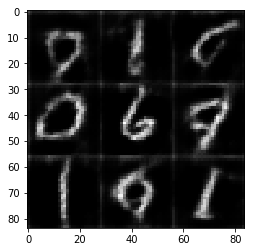

Training step: 1620, Discriminator loss: 1.598, Generator loss: 0.839

Training step: 1640, Discriminator loss: 0.621, Generator loss: 1.118

Training step: 1660, Discriminator loss: 0.492, Generator loss: 1.506

Training step: 1680, Discriminator loss: 0.625, Generator loss: 1.214

Training step: 1700, Discriminator loss: 0.741, Generator loss: 1.102



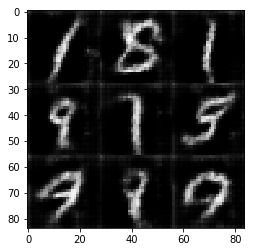

Training step: 1720, Discriminator loss: 0.615, Generator loss: 1.039

Training step: 1740, Discriminator loss: 0.560, Generator loss: 1.393

Training step: 1760, Discriminator loss: 0.479, Generator loss: 1.769

Training step: 1780, Discriminator loss: 0.454, Generator loss: 1.435

Training step: 1800, Discriminator loss: 0.626, Generator loss: 1.001



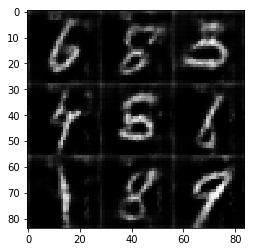

Training step: 1820, Discriminator loss: 0.780, Generator loss: 1.984

Training step: 1840, Discriminator loss: 0.557, Generator loss: 1.283

Training step: 1860, Discriminator loss: 0.629, Generator loss: 1.539



In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Training step: 20, Discriminator loss: 1.387, Generator loss: 0.470

Training step: 40, Discriminator loss: 1.308, Generator loss: 0.532

Training step: 60, Discriminator loss: 1.038, Generator loss: 0.742

Training step: 80, Discriminator loss: 0.877, Generator loss: 0.871

Training step: 100, Discriminator loss: 0.883, Generator loss: 0.837



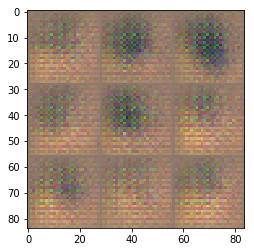

Training step: 120, Discriminator loss: 0.859, Generator loss: 0.952

Training step: 140, Discriminator loss: 0.994, Generator loss: 0.851

Training step: 160, Discriminator loss: 0.896, Generator loss: 0.897

Training step: 180, Discriminator loss: 1.197, Generator loss: 0.885

Training step: 200, Discriminator loss: 0.825, Generator loss: 0.905



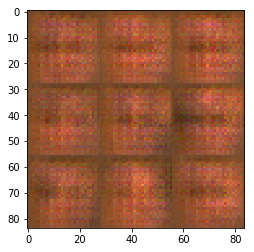

Training step: 220, Discriminator loss: 0.821, Generator loss: 0.914

Training step: 240, Discriminator loss: 0.676, Generator loss: 1.180

Training step: 260, Discriminator loss: 0.945, Generator loss: 0.629

Training step: 280, Discriminator loss: 0.977, Generator loss: 0.740

Training step: 300, Discriminator loss: 0.627, Generator loss: 2.498



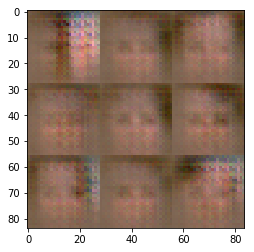

Training step: 320, Discriminator loss: 0.496, Generator loss: 1.353

Training step: 340, Discriminator loss: 0.274, Generator loss: 1.925

Training step: 360, Discriminator loss: 0.373, Generator loss: 1.594

Training step: 380, Discriminator loss: 0.730, Generator loss: 1.172

Training step: 400, Discriminator loss: 0.708, Generator loss: 1.689



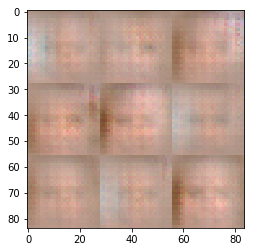

Training step: 420, Discriminator loss: 0.724, Generator loss: 1.147

Training step: 440, Discriminator loss: 0.731, Generator loss: 1.075

Training step: 460, Discriminator loss: 0.742, Generator loss: 1.196

Training step: 480, Discriminator loss: 0.862, Generator loss: 1.042

Training step: 500, Discriminator loss: 0.782, Generator loss: 1.552



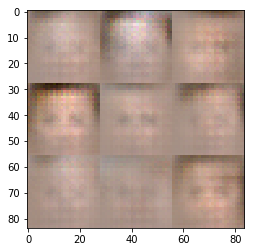

Training step: 520, Discriminator loss: 1.495, Generator loss: 0.455

Training step: 540, Discriminator loss: 0.585, Generator loss: 1.471

Training step: 560, Discriminator loss: 0.822, Generator loss: 1.468

Training step: 580, Discriminator loss: 0.805, Generator loss: 1.444

Training step: 600, Discriminator loss: 0.805, Generator loss: 1.074



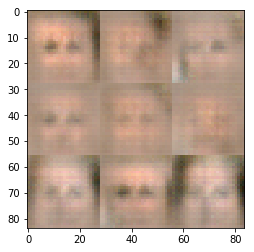

Training step: 620, Discriminator loss: 0.949, Generator loss: 1.214

Training step: 640, Discriminator loss: 1.044, Generator loss: 0.680

Training step: 660, Discriminator loss: 0.540, Generator loss: 1.771

Training step: 680, Discriminator loss: 0.604, Generator loss: 1.466

Training step: 700, Discriminator loss: 0.691, Generator loss: 2.286



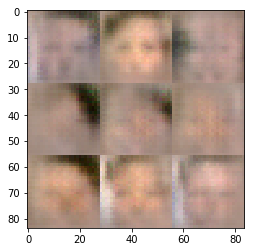

Training step: 720, Discriminator loss: 0.539, Generator loss: 1.914

Training step: 740, Discriminator loss: 0.605, Generator loss: 1.610

Training step: 760, Discriminator loss: 0.770, Generator loss: 1.982

Training step: 780, Discriminator loss: 0.997, Generator loss: 2.260

Training step: 800, Discriminator loss: 0.809, Generator loss: 1.023



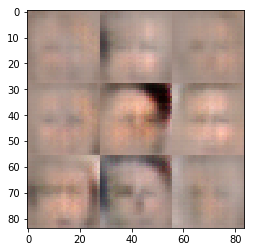

Training step: 820, Discriminator loss: 0.658, Generator loss: 1.147

Training step: 840, Discriminator loss: 0.999, Generator loss: 0.641

Training step: 860, Discriminator loss: 0.498, Generator loss: 1.756

Training step: 880, Discriminator loss: 0.639, Generator loss: 2.059

Training step: 900, Discriminator loss: 1.176, Generator loss: 1.150



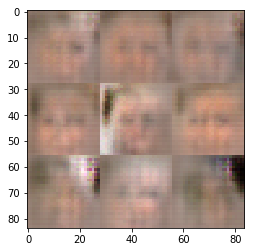

Training step: 920, Discriminator loss: 0.671, Generator loss: 1.161

Training step: 940, Discriminator loss: 0.837, Generator loss: 0.796

Training step: 960, Discriminator loss: 0.778, Generator loss: 1.180

Training step: 980, Discriminator loss: 0.627, Generator loss: 1.081

Training step: 1000, Discriminator loss: 1.131, Generator loss: 0.610



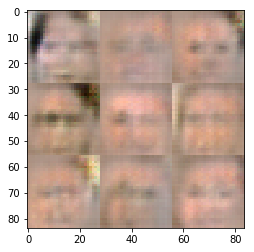

Training step: 1020, Discriminator loss: 0.409, Generator loss: 2.079

Training step: 1040, Discriminator loss: 0.701, Generator loss: 1.286

Training step: 1060, Discriminator loss: 0.525, Generator loss: 1.546

Training step: 1080, Discriminator loss: 1.091, Generator loss: 1.056

Training step: 1100, Discriminator loss: 1.082, Generator loss: 0.572



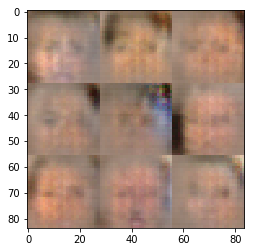

Training step: 1120, Discriminator loss: 0.549, Generator loss: 2.351

Training step: 1140, Discriminator loss: 0.736, Generator loss: 1.092

Training step: 1160, Discriminator loss: 1.094, Generator loss: 0.980

Training step: 1180, Discriminator loss: 0.743, Generator loss: 1.102

Training step: 1200, Discriminator loss: 0.961, Generator loss: 0.877



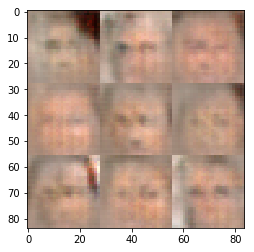

Training step: 1220, Discriminator loss: 0.645, Generator loss: 1.536

Training step: 1240, Discriminator loss: 0.620, Generator loss: 1.445

Training step: 1260, Discriminator loss: 0.854, Generator loss: 0.868

Training step: 1280, Discriminator loss: 0.918, Generator loss: 1.108

Training step: 1300, Discriminator loss: 1.033, Generator loss: 0.750



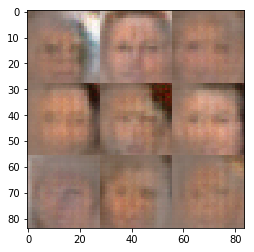

Training step: 1320, Discriminator loss: 0.792, Generator loss: 0.915

Training step: 1340, Discriminator loss: 1.002, Generator loss: 1.108

Training step: 1360, Discriminator loss: 0.876, Generator loss: 0.841

Training step: 1380, Discriminator loss: 0.798, Generator loss: 0.976

Training step: 1400, Discriminator loss: 0.787, Generator loss: 0.908



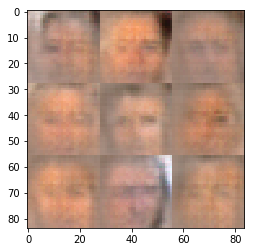

Training step: 1420, Discriminator loss: 0.619, Generator loss: 1.307

Training step: 1440, Discriminator loss: 0.711, Generator loss: 0.929

Training step: 1460, Discriminator loss: 1.004, Generator loss: 0.703

Training step: 1480, Discriminator loss: 0.902, Generator loss: 0.955

Training step: 1500, Discriminator loss: 0.819, Generator loss: 1.131



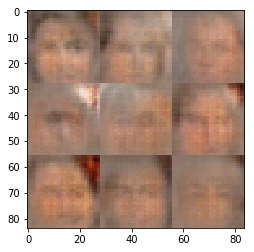

Training step: 1520, Discriminator loss: 0.946, Generator loss: 1.042

Training step: 1540, Discriminator loss: 0.605, Generator loss: 1.721

Training step: 1560, Discriminator loss: 0.894, Generator loss: 0.925

Training step: 1580, Discriminator loss: 0.543, Generator loss: 1.372

Training step: 1600, Discriminator loss: 0.791, Generator loss: 1.033



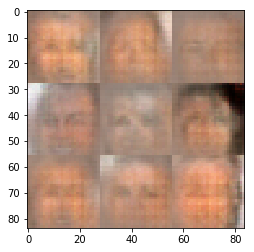

Training step: 1620, Discriminator loss: 0.850, Generator loss: 1.755

Training step: 1640, Discriminator loss: 0.563, Generator loss: 1.469

Training step: 1660, Discriminator loss: 0.927, Generator loss: 0.858

Training step: 1680, Discriminator loss: 0.665, Generator loss: 1.066

Training step: 1700, Discriminator loss: 0.588, Generator loss: 1.398



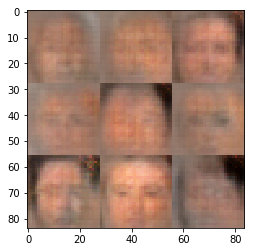

Training step: 1720, Discriminator loss: 0.800, Generator loss: 1.113

Training step: 1740, Discriminator loss: 0.750, Generator loss: 1.159

Training step: 1760, Discriminator loss: 0.506, Generator loss: 1.513

Training step: 1780, Discriminator loss: 0.591, Generator loss: 1.316

Training step: 1800, Discriminator loss: 0.706, Generator loss: 1.182



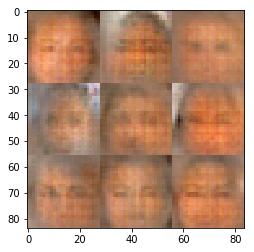

Training step: 1820, Discriminator loss: 0.770, Generator loss: 0.921

Training step: 1840, Discriminator loss: 1.108, Generator loss: 1.099

Training step: 1860, Discriminator loss: 1.021, Generator loss: 0.677

Training step: 1880, Discriminator loss: 0.656, Generator loss: 1.268

Training step: 1900, Discriminator loss: 0.906, Generator loss: 0.800



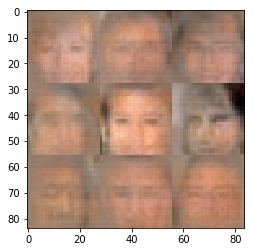

Training step: 1920, Discriminator loss: 0.942, Generator loss: 1.993

Training step: 1940, Discriminator loss: 0.796, Generator loss: 1.216

Training step: 1960, Discriminator loss: 1.311, Generator loss: 0.523

Training step: 1980, Discriminator loss: 0.454, Generator loss: 1.574

Training step: 2000, Discriminator loss: 0.737, Generator loss: 1.076



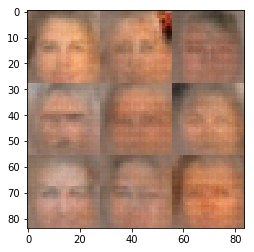

Training step: 2020, Discriminator loss: 0.577, Generator loss: 1.596

Training step: 2040, Discriminator loss: 0.947, Generator loss: 1.439

Training step: 2060, Discriminator loss: 0.538, Generator loss: 1.492

Training step: 2080, Discriminator loss: 0.752, Generator loss: 1.733

Training step: 2100, Discriminator loss: 1.105, Generator loss: 0.862



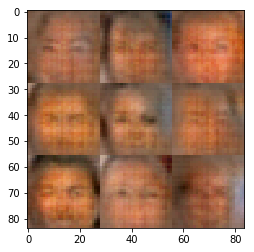

Training step: 2120, Discriminator loss: 0.891, Generator loss: 0.971

Training step: 2140, Discriminator loss: 0.668, Generator loss: 1.155

Training step: 2160, Discriminator loss: 0.598, Generator loss: 1.202

Training step: 2180, Discriminator loss: 0.904, Generator loss: 0.758

Training step: 2200, Discriminator loss: 0.656, Generator loss: 1.364



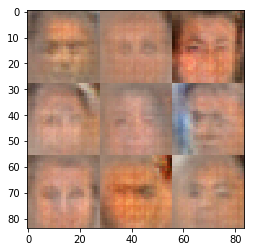

Training step: 2220, Discriminator loss: 0.679, Generator loss: 1.624

Training step: 2240, Discriminator loss: 0.738, Generator loss: 1.472

Training step: 2260, Discriminator loss: 0.706, Generator loss: 1.859

Training step: 2280, Discriminator loss: 0.862, Generator loss: 1.095

Training step: 2300, Discriminator loss: 0.597, Generator loss: 1.699



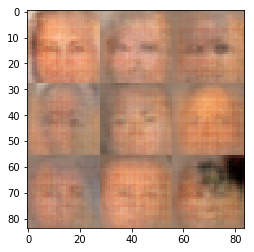

Training step: 2320, Discriminator loss: 0.660, Generator loss: 0.989

Training step: 2340, Discriminator loss: 0.838, Generator loss: 0.773

Training step: 2360, Discriminator loss: 0.696, Generator loss: 1.304

Training step: 2380, Discriminator loss: 1.804, Generator loss: 0.262

Training step: 2400, Discriminator loss: 0.915, Generator loss: 0.752



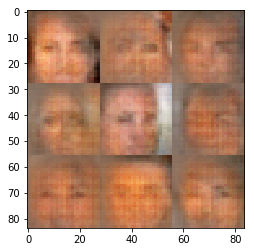

Training step: 2420, Discriminator loss: 0.614, Generator loss: 1.565

Training step: 2440, Discriminator loss: 0.654, Generator loss: 1.282

Training step: 2460, Discriminator loss: 0.603, Generator loss: 1.212

Training step: 2480, Discriminator loss: 0.757, Generator loss: 1.644

Training step: 2500, Discriminator loss: 0.705, Generator loss: 1.348



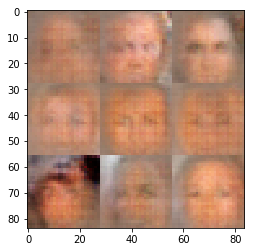

Training step: 2520, Discriminator loss: 0.513, Generator loss: 1.582

Training step: 2540, Discriminator loss: 0.684, Generator loss: 2.046

Training step: 2560, Discriminator loss: 0.788, Generator loss: 0.896

Training step: 2580, Discriminator loss: 0.771, Generator loss: 0.895

Training step: 2600, Discriminator loss: 0.526, Generator loss: 1.370



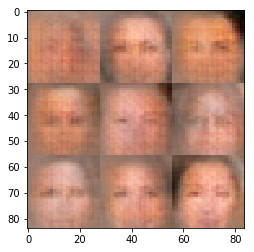

Training step: 2620, Discriminator loss: 0.495, Generator loss: 1.661

Training step: 2640, Discriminator loss: 1.068, Generator loss: 0.679

Training step: 2660, Discriminator loss: 0.871, Generator loss: 0.945

Training step: 2680, Discriminator loss: 0.850, Generator loss: 0.982

Training step: 2700, Discriminator loss: 0.568, Generator loss: 1.304



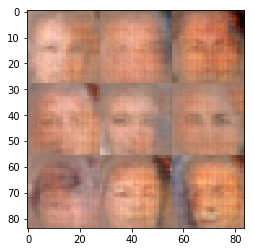

Training step: 2720, Discriminator loss: 0.851, Generator loss: 1.070

Training step: 2740, Discriminator loss: 0.657, Generator loss: 1.170

Training step: 2760, Discriminator loss: 0.717, Generator loss: 1.516

Training step: 2780, Discriminator loss: 0.656, Generator loss: 1.053

Training step: 2800, Discriminator loss: 0.938, Generator loss: 2.583



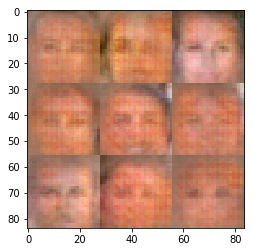

Training step: 2820, Discriminator loss: 0.531, Generator loss: 1.475

Training step: 2840, Discriminator loss: 0.619, Generator loss: 1.230

Training step: 2860, Discriminator loss: 0.563, Generator loss: 1.363

Training step: 2880, Discriminator loss: 0.524, Generator loss: 1.229

Training step: 2900, Discriminator loss: 0.479, Generator loss: 1.476



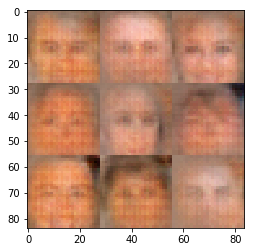

Training step: 2920, Discriminator loss: 0.676, Generator loss: 0.975

Training step: 2940, Discriminator loss: 0.458, Generator loss: 1.479

Training step: 2960, Discriminator loss: 1.016, Generator loss: 0.622

Training step: 2980, Discriminator loss: 0.616, Generator loss: 1.288

Training step: 3000, Discriminator loss: 0.677, Generator loss: 1.003



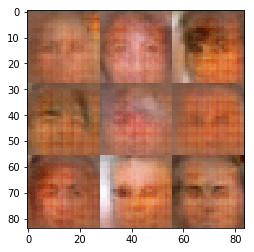

Training step: 3020, Discriminator loss: 0.578, Generator loss: 1.380

Training step: 3040, Discriminator loss: 0.618, Generator loss: 1.265

Training step: 3060, Discriminator loss: 1.496, Generator loss: 0.314

Training step: 3080, Discriminator loss: 0.879, Generator loss: 0.809

Training step: 3100, Discriminator loss: 0.790, Generator loss: 1.005



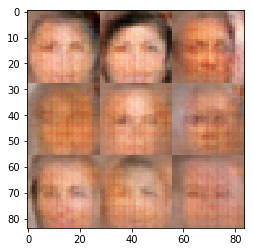

Training step: 3120, Discriminator loss: 0.408, Generator loss: 1.687

Training step: 3140, Discriminator loss: 0.643, Generator loss: 1.247

Training step: 3160, Discriminator loss: 0.572, Generator loss: 1.185



In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.